the objective of this notebook is to examine the likelihood functional form of the group multiplicity function. to do so, I will generate a series of mock galaxy catalogs using halotools, then look at the likelihood function using the mock catalogs. 

In [4]:
import os
import numpy as np
import pickle

import env
import util as UT
import nongauss as NG

In [5]:
from halotools.sim_manager import CachedHaloCatalog
from halotools.empirical_models import PrebuiltHodModelFactory
from halotools.empirical_models.factories.mock_helpers import three_dim_pos_bundle
from halotools.mock_observables import FoFGroups
from astropy.table import Table

In [6]:
from skl_groups.divergences import KNNDivergenceEstimator
from skl_groups.features import Features

In [7]:
import matplotlib as mpl 
import matplotlib.pyplot as plt 
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline

In [8]:
def edge(index):
    zi = (index / 25) * 200.
    i2 = index % 25
    yi = (i2 / 5) * 200.
    i3 = i2 % 5
    xi = (i3) * 200.
    return xi , yi , zi

def mask_galaxy_table(pos , subvol_index):
    xi , yi , zi  = edge(subvol_index)
    submask = np.where((xi <pos[:, 0]) * \
                       (pos[:, 0] < xi + 200) * \
                       (yi <pos[:, 1]) * \
                       (pos[:, 1] < yi + 200) * \
                       (zi <pos[:, 2]) *  \
                       (pos[:, 2] < zi + 200))
    return pos[submask]

In [9]:
def richness(group_id):
    '''Calculate the richness of a group given group_ids of galaxies. Uses astropy.table module
    '''
    gals = Table()
    gals['groupid'] = group_id
    gals['dummy'] = 1
    grouped_table = gals.group_by('groupid')
    grp_richness = grouped_table['dummy'].groups.aggregate(np.sum)
    return np.array(grp_richness)

In [10]:
model = PrebuiltHodModelFactory('zheng07', threshold=-21)
halocat = CachedHaloCatalog(simname='multidark', redshift=0, halo_finder='rockstar')

In [11]:
b_perp = 0.14
b_para = 0.75
gmf_bins = np.array([5,7,10,14,20,28,40])

In [12]:
gmf_file = ''.join([UT.dat_dir(), 'submultidark.gmf.p'])
if os.path.isfile(gmf_file): 
    gmf_dict = pickle.load(open(gmf_file, 'rb'))
    gmfs = gmf_dict['gmfs']
else: 
    nbars, gmfs = [], []
    for i in range(1, 125): 
        print 'mock #', i
        model.populate_mock(halocat) # populate the halo catalog
        pos = three_dim_pos_bundle(model.mock.galaxy_table, 'x', 'y', 'z')
        pos = mask_galaxy_table(pos , i)
    
        nbars.append(len(pos) / 200**3.)
        groups = FoFGroups(pos, b_perp, b_para, period=200)
        gmf_i = np.histogram(richness(groups.group_ids), gmf_bins)[0]/200.**3
        gmfs.append(gmf_i)
    
    # save gmfs to file 
    gmf_dict = {'gmf_bins': gmf_bins, 'gmfs': gmfs}
    pickle.dump(gmf_dict, open(gmf_file, 'wb'))

124


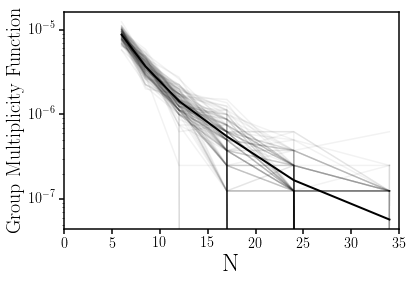

In [13]:
fig = plt.figure()
sub = fig.add_subplot(111)
print np.array(gmfs).shape[0]
for gmf in gmfs: 
    sub.plot(0.5*(gmf_bins[1:] + gmf_bins[:-1]), gmf, c='k', alpha=0.05)
sub.plot(0.5*(gmf_bins[1:] + gmf_bins[:-1]), (np.sum(np.array(gmfs), axis=0)/float(len(gmfs))), c='k', lw=2)
sub.set_xlim([0.,35])
sub.set_xlabel('N', fontsize=25)
sub.set_ylabel('Group Multiplicity Function', fontsize=20)
sub.set_yscale("log")

Now we can use the GMFs to calculate covariance matrix

In [14]:
# compute average GMF
gmf_avg = (np.sum(np.array(gmfs), axis=0)/float(len(gmfs)))[2:]

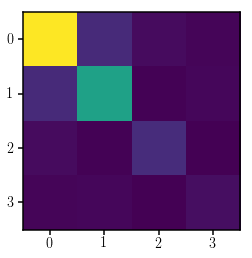

In [15]:
plt.imshow(np.cov((np.array(gmfs)[:,2:]).T))

In [17]:
# first we whiten the data
#gmfs_white, W = NG.whiten(np.array(gmfs) - gmf_avg)
gmfs_white, W = NG.whiten(np.array(gmfs)[:,2:] - gmf_avg, method='stddev_scale')

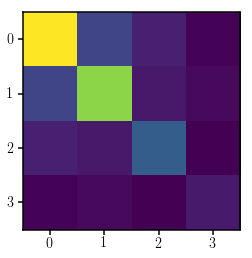

In [18]:
C_gmf = np.cov(gmfs_white.T)
plt.imshow(C_gmf)

Now the question is, how does the pdf of the GMFs diverge from a multivariate Gaussian with covariance $C_\mathrm{gmf}$? One way to quantify this is to calculate the divergence between the GMFs and a multivare Gaussian

In [19]:
mvn = np.random.multivariate_normal

In [20]:
gauss = mvn(np.zeros(len(gmf_avg)), C_gmf, size=1000) # reference Gaussian distribution

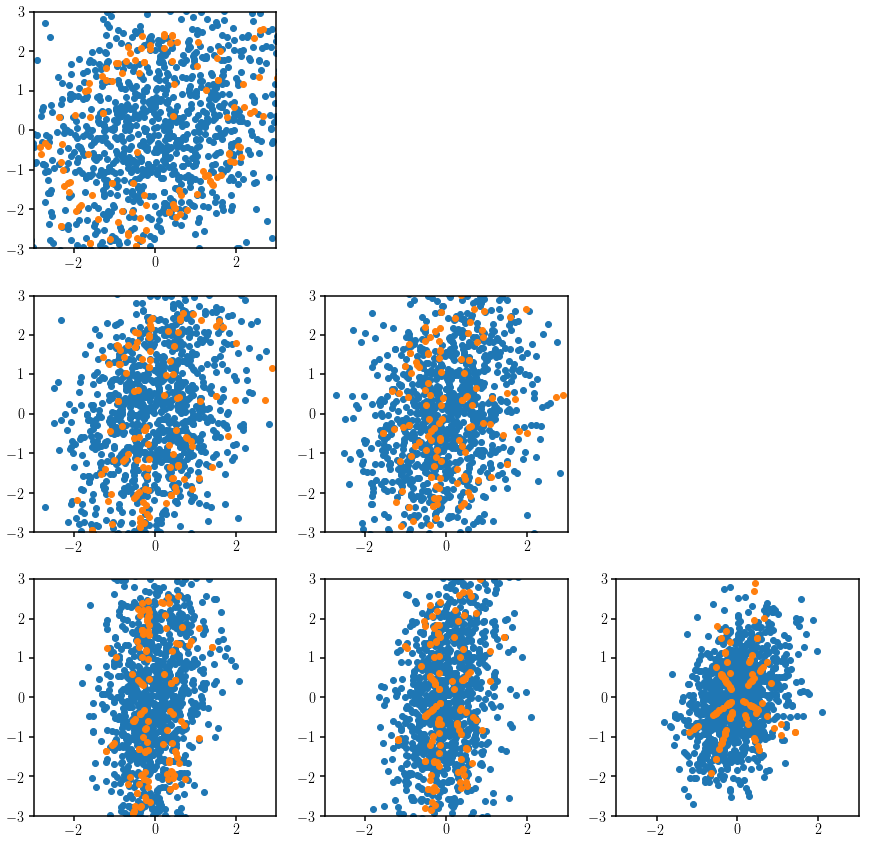

In [35]:
fig = plt.figure(figsize=(20,20))
for i in range(len(gmf_avg)): 
    for j in range(len(gmf_avg)): 
        if i > j: 
            sub = fig.add_subplot(len(gmf_avg), len(gmf_avg), len(gmf_avg)*i+j+1)
            sub.scatter(gauss[:,i], gauss[:,j])
            sub.scatter(gmfs_white[:,i], gmfs_white[:,j])
            sub.set_xlim([-3., 3.])
            sub.set_ylim([-3., 3.])

In [23]:
div_knns = []
n = 200 
for i in range(n): 
    gauss = mvn(np.zeros(len(gmf_avg)), C_gmf, size=1000) # reference Gaussian distribution
    kNN = KNNDivergenceEstimator(div_funcs=["renyi:.5"], Ks=[1,2,3,4,5], version='slow', clamp=False)
    feat = Features([gmfs_white, gauss])
    div_knn_i = kNN.fit_transform(feat)
    if i == 0: 
        div_knn = div_knn_i
    else: 
        div_knn += div_knn_i #kNN.fit_transform(feat)
    div_knns.append(div_knn_i)
div_knn /= float(n)

In [24]:
div_1nn_1to2, div_2nn_1to2, div_3nn_1to2, div_4nn_1to2, div_5nn_1to2 = [], [], [], [], []
for i in range(1000): 
    gauss = mvn(np.zeros(len(gmf_avg)), C_gmf, size=1000) # reference Gaussian distribution
    gauss2 = mvn(np.zeros(len(gmf_avg)), C_gmf, size=len(gmfs))
    kNN = KNNDivergenceEstimator(div_funcs=["renyi:.5"], Ks=[1,2,3,4,5], version='slow', clamp=False)
    feat = Features([gauss2, gauss])
    div_knn_i = kNN.fit_transform(feat)
    div_1nn_1to2.append(div_knn_i[0][0][0][1])
    div_2nn_1to2.append(div_knn_i[0][1][0][1])
    div_3nn_1to2.append(div_knn_i[0][2][0][1])
    div_4nn_1to2.append(div_knn_i[0][3][0][1])
    div_5nn_1to2.append(div_knn_i[0][4][0][1])

In [25]:
div_knn_1to2 = [div_1nn_1to2, div_2nn_1to2, div_3nn_1to2, div_4nn_1to2, div_5nn_1to2]

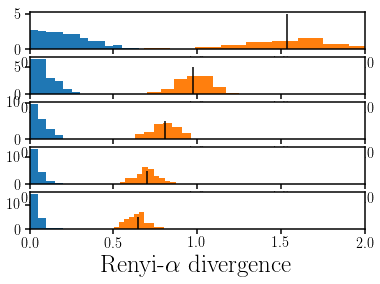

In [26]:
fig = plt.figure()
for i in range(1, 6):
    sub = fig.add_subplot(5,1,i)

    _ = sub.hist(div_knn_1to2[i-1], normed=True, range=[0., 2.], bins=40)
    _ = sub.hist([div[0][i-1][0][1] for div in div_knns], normed=True)
    #print div_knn[0][0][0][1]
    sub.vlines(div_knn[0][i-1][0][1], 0, 5)
    sub.set_xlim([0., 2.])
sub.set_xlabel(r'Renyi-$\alpha$ divergence', fontsize=25)

In [27]:
div_knns = []
n = 200 
for i in range(n): 
    gauss = mvn(np.zeros(len(gmf_avg)), C_gmf, size=1000) # reference Gaussian distribution
    kNN = KNNDivergenceEstimator(div_funcs=["kl"], Ks=[1,2,3,4,5], version='slow', clamp=False)
    feat = Features([gmfs_white, gauss])
    div_knn_i = kNN.fit_transform(feat)
    if i == 0: 
        div_knn = div_knn_i
    else: 
        div_knn += div_knn_i #kNN.fit_transform(feat)
    div_knns.append(div_knn_i)
div_knn /= float(n)

In [28]:
div_1nn_1to2, div_2nn_1to2, div_3nn_1to2, div_4nn_1to2, div_5nn_1to2 = [], [], [], [], []
for i in range(1000): 
    gauss = mvn(np.zeros(len(gmf_avg)), C_gmf, size=1000) # reference Gaussian distribution
    gauss2 = mvn(np.zeros(len(gmf_avg)), C_gmf, size=len(gmfs))
    kNN = KNNDivergenceEstimator(div_funcs=["kl"], Ks=[1,2,3,4,5], version='slow', clamp=False)
    feat = Features([gauss2, gauss])
    div_knn_i = kNN.fit_transform(feat)
    div_1nn_1to2.append(div_knn_i[0][0][0][1])
    div_2nn_1to2.append(div_knn_i[0][1][0][1])
    div_3nn_1to2.append(div_knn_i[0][2][0][1])
    div_4nn_1to2.append(div_knn_i[0][3][0][1])
    div_5nn_1to2.append(div_knn_i[0][4][0][1])
div_knn_1to2 = [div_1nn_1to2, div_2nn_1to2, div_3nn_1to2, div_4nn_1to2, div_5nn_1to2]

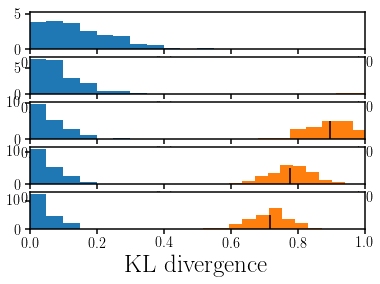

In [30]:
fig = plt.figure()
for i in range(1, 6):
    sub = fig.add_subplot(5,1,i)

    _ = sub.hist(div_knn_1to2[i-1], normed=True, range=[0., 2.], bins=40)
    _ = sub.hist([div[0][i-1][0][1] for div in div_knns], normed=True)
    sub.vlines(div_knn[0][i-1][0][1], 0, 5)
    sub.set_xlim([0., 1.])
sub.set_xlabel(r'KL divergence', fontsize=25)

the main conclusions of this notebook are: 
- nonparameteric estimators of Renyi-$\alpha$ or KL divergence identify significant discrepancies for $N > 10$ between the likelihood pdf from the mock GMFs versus the Gaussian pseudo-likelihood described by the covariance matrix. 
- there are some nuances to using the nonparametric estimators. For instance $k$ depends on the sample size of the $\{X_{1:n}\}$ and $\{Y_{1:m}\}$. 